# Network Analysis for Information Retrieval - Part 3

Elyes KHALFALLAH & Mohammed ali EL ADLOUNI

16/03/2025

---

---


## Exercice 7 : Prise en compte de la structure du corpus

In [1]:
# Useful libraries
import numpy as np
import pandas as pd
from fonctions import *
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
# Nous allons maintenant construire la matrice Documents x Termes en adoprant le schéma de pondération TF-IDF

# Load the data
data_text = pd.read_csv("data_text.csv")
print(data_text.shape)

(40596, 10)


In [3]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40596 entries, 0 to 40595
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        40595 non-null  object
 1   venue       40596 non-null  object
 2   abstract    18013 non-null  object
 3   authors     40596 non-null  object
 4   n_citation  40596 non-null  int64 
 5   references  27246 non-null  object
 6   title       40596 non-null  object
 7   year        40596 non-null  int64 
 8   id          40596 non-null  object
 9   class       40596 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 3.1+ MB


In [4]:
data_text

,text,venue,abstract,authors,n_citation,references,title,year,id,class
0,human interaction preliminary protocol tool co...,international conference on human-computer int...,The purpose of this study is to develop a lear...,"['Makoto Satoh', 'Ryo Muramatsu', 'Mizue Kayam...",0,"['51c7e02e-f5ed-431a-8cf5-f761f266d4be', '69b6...",Preliminary Design of a Network Protocol Learn...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,3
1,visual analytics science methodology physicall...,visual analytics science and technology,This paper describes the design and implementa...,"['Gareth Beale', 'Graeme Earl']",50,"['10482dd3-4642-4193-842f-85f3b70fcf65', '3133...",A methodology for the physically accurate visu...,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,3
2,pattern recognition machine comparison garch n...,pattern recognition and machine intelligence,This article applied GARCH model instead AR or...,"['Altaf Hossain', 'Faisal Zaman', 'Mohammed Na...",50,"['2d84c0f2-e656-4ce7-b018-90eda1c132fe', 'a083...","Comparison of GARCH, Neural Network and Suppor...",2009,001c8744-73c4-4b04-9364-22d31a10dbf1,4
3,graphic theory comparing gng3d quadric error m...,international conference on computer graphics ...,NaN,"['Rafael Álvarez', 'Leandro Tortosa', 'José-Fr...",0,NaN,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,2009,005ce28f-ed77-4e97-afdc-a296137186a1,5
4,symposium science improved secret sharing enco...,international symposium on computer and inform...,NaN,"['Guzin Ulutas', 'Mustafa Ulutas', 'Vasif V. N...",0,"['5626736c-e434-4e2d-8405-54940fab88ab', '8e87...",Improved Secret Image Sharing Method By Encodi...,2011,00701b05-684f-45f9-b281-425abfec482c,8
...,...,...,...,...,...,...,...,...,...,...
40591,distributed operation management crawling bug ...,distributed systems operations and management,The Web has become an important knowledge sour...,"['Ha Manh Tran', 'Georgi Chulkov', 'Jürgen Sch...",50,"['059b27e8-3e7b-414a-9e7c-3e9db05cf36a', '0895...",Crawling Bug Tracker for Semantic Bug Search,2008,ad5cd708-c41c-4721-aade-b02a07c06549,2
40592,asia retrieval symposium topic assisted fusion...,asia information retrieval symposium,NaN,"['Rajendra Prasath', 'Aidan Maurice Duane', 'P...",0,"['312d09d9-7a76-468c-966d-c08951d7efcb', '66c5...",Topic Assisted Fusion to Re-rank Texts for Mul...,2013,ad61e69a-291b-411a-8d1a-21bb9bac58a9,5
40593,pacific asia apparel trade quotation architect...,pacific asia conference on information systems,NaN,"['Qian Li', 'Yu Chen', 'Lanfang Zhang']",0,"['2a4f089a-b0b8-4387-ba78-9f22e95dd851', 'd777...",An Apparel Trade quotation Architecture Based ...,2009,ad663004-8b45-4e83-bd7c-1cf5f952c11e,2
40594,european warfare security common operational p...,european conference on information warfare and...,NaN,"['Rauno Kuusisto', 'Tuija Kuusisto', 'Leigh Ar...",4,[],"Common Operational Picture, Situation Awarenes...",2005,ad71c738-defc-4707-9537-699a8c15fe47,5


In [5]:
from scipy.sparse import csr_matrix

# Assume df is your DataFrame
# Factorize the 'venue' column to get numeric codes
venue_codes, unique_venues = pd.factorize(data_text['venue'])
print(len(venue_codes))
print(len(unique_venues))

print(venue_codes)
print(unique_venues)

n = len(data_text)



40596
1701
[  0   1   2 ...  45 566 879]
Index(['international conference on human-computer interaction',
       'visual analytics science and technology',
       'pattern recognition and machine intelligence',
       'international conference on computer graphics theory and applications',
       'international symposium on computer and information sciences',
       'parallel and distributed processing techniques and applications',
       'international conference on computer vision and graphics',
       'international conference on conceptual structures',
       'international joint conference on artificial intelligence',
       'Electronic Notes in Theoretical Computer Science',
       ...
       'verified software: theories, tools, experiments',
       'Data Science Journal',
       'symbolic and numeric algorithms for scientific computing',
       'virtual systems and multimedia',
       'international work conference on the interplay between natural and artificial computation',
  

In [6]:
# Create a sparse indicator matrix: each article (row) gets a 1 at its venue (column)
data = np.ones(n, dtype=int)
row_indices = np.arange(n)
col_indices = venue_codes

# Build the sparse matrix (shape: [n_articles x n_unique_venues])
M = csr_matrix((data, (row_indices, col_indices)), shape=(n, len(unique_venues)))

# Compute the adjacency matrix as the dot product of M with its transpose
# Each off-diagonal entry is 1 if the two articles share the same venue; diagonal entries are 1 as well.
adjacency_matrix = M.dot(M.T)

# If needed, convert to a dense NumPy array (note: this might be memory intensive for large n)
# adjacency_dense = adjacency_matrix.toarray()


In [7]:
adjacency_matrix.shape

(40596, 40596)

In [8]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Convert the sparse adjacency matrix to a NetworkX graph.
# Each node corresponds to an article.
G = nx.from_scipy_sparse_array(adjacency_matrix)


Degree Distribution:
Degree 0: 0 nodes
Degree 1: 0 nodes
Degree 2: 354 nodes
Degree 3: 332 nodes
Degree 4: 261 nodes
Degree 5: 364 nodes
Degree 6: 360 nodes
Degree 7: 348 nodes
Degree 8: 301 nodes
Degree 9: 368 nodes
Degree 10: 459 nodes
Degree 11: 400 nodes
Degree 12: 242 nodes
Degree 13: 456 nodes
Degree 14: 403 nodes
Degree 15: 350 nodes
Degree 16: 390 nodes
Degree 17: 416 nodes
Degree 18: 476 nodes
Degree 19: 342 nodes
Degree 20: 494 nodes
Degree 21: 480 nodes
Degree 22: 399 nodes
Degree 23: 440 nodes
Degree 24: 368 nodes
Degree 25: 264 nodes
Degree 26: 425 nodes
Degree 27: 260 nodes
Degree 28: 270 nodes
Degree 29: 336 nodes
Degree 30: 261 nodes
Degree 31: 270 nodes
Degree 32: 93 nodes
Degree 33: 192 nodes
Degree 34: 363 nodes
Degree 35: 170 nodes
Degree 36: 175 nodes
Degree 37: 216 nodes
Degree 38: 296 nodes
Degree 39: 266 nodes
Degree 40: 351 nodes
Degree 41: 200 nodes
Degree 42: 246 nodes
Degree 43: 336 nodes
Degree 44: 215 nodes
Degree 45: 176 nodes
Degree 46: 225 nodes
Degree 

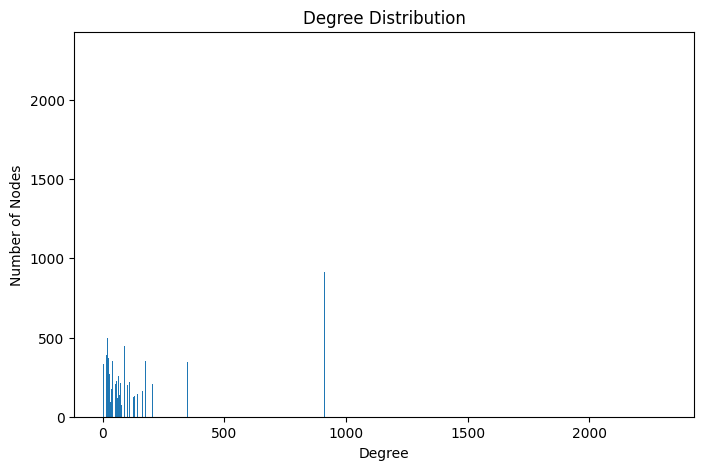

In [9]:
# --- Degree Distribution ---
# Get degrees of all nodes.
degrees = [degree for node, degree in G.degree()]
# Compute a histogram of degrees.
hist, bin_edges = np.histogram(degrees, bins=range(max(degrees) + 2))
print("Degree Distribution:")
for deg, count in zip(bin_edges[:-1], hist):
    print(f"Degree {deg}: {count} nodes")

# Optionally, plot the degree distribution.
plt.figure(figsize=(8, 5))
plt.bar(bin_edges[:-1], hist, width=0.8, align='center')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.title('Degree Distribution')
plt.show()


In [10]:
# --- Graph Density ---
density = nx.density(G)
print("Graph Density:", density)

# --- Graph Width ---
# Here, 'width' can be interpreted in a couple of ways.
# For example, you might consider the maximum degree as a measure of the graph's width.
max_degree = max(degrees)
print("Graph Width (Maximum Degree):", max_degree)

# --- Graph Diameter ---
# Note: The diameter is defined only for connected graphs.
# If the graph is disconnected, you can compute the diameter of each connected component.
if nx.is_connected(G):
    diameter = nx.diameter(G)
    print("Graph Diameter:", diameter)
else:
    # Compute diameters for each connected component (ignoring isolated nodes)
    components = [G.subgraph(c).copy() for c in nx.connected_components(G) if len(c) > 1]
    diameters = [nx.diameter(comp) for comp in components]
    print("Graph is not fully connected. Diameters of connected components:", diameters)

# # --- Clustering Coefficients ---
# # Compute the clustering coefficient for each node.
# clustering_coeffs = nx.clustering(G)
# # Calculate the average clustering coefficient.
# avg_clustering = np.mean(list(clustering_coeffs.values()))
# print("Average Clustering Coefficient:", avg_clustering)


Graph Density: 0.006825693399411704
Graph Width (Maximum Degree): 2316
Graph is not fully connected. Diameters of connected components: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import ipysigma as sigma

# --- Step 1: Add Node Attributes ---
# Assume df is your DataFrame and G is the NetworkX graph (with nodes 0 to n-1)
# that was built from your adjacency matrix.
# We assume the order of rows in df corresponds to the node IDs in G.
for i, row in data_text.iterrows():
    # Here, we use the 'class' column as the dominant theme.
    G.nodes[i]['theme'] = row['class']
    # Optionally, you can add a label (like the article title) to make the visualization more informative:
    G.nodes[i]['label'] = row['title']

# --- Step 2: Map Themes to Colors ---
# Collect all unique themes.
themes = [G.nodes[n]['theme'] for n in G.nodes()]
unique_themes = sorted(set(themes))

# Create a colormap using matplotlib's tab10 (or any other colormap).
cmap = cm.get_cmap('tab10', len(unique_themes))
theme_color_mapping = {theme: mcolors.rgb2hex(cmap(i)) for i, theme in enumerate(unique_themes)}

# Assign a color attribute to each node based on its theme.
for n in G.nodes():
    theme = G.nodes[n]['theme']
    G.nodes[n]['color'] = theme_color_mapping.get(theme, "#cccccc")  # default color if theme not found

# # --- Step 3: Visualize using ipysigma ---
# # Create an interactive sigma visualization of the graph.
# vis = sigma.Sigma(G)
# vis


C:\Users\medal\AppData\Local\Temp\ipykernel_23816\3488737109.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_themes))


In [19]:
import random
import ipysigma as sigma

# Sample a subset of nodes (e.g., 500 nodes)
sample_size = 250  # Adjust this number based on performance
sample_nodes = random.sample(list(G.nodes()), sample_size)
G_sub = G.subgraph(sample_nodes)

# Visualize the subgraph
vis = sigma.Sigma(G_sub)
vis


Sigma(nx.Graph with 250 nodes and 450 edges)

In [20]:
import networkx as nx

# Identify the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_cc)

# Visualize the largest connected component
vis = sigma.Sigma(G_largest)
vis


Sigma(nx.Graph with 2,315 nodes and 2,680,770 edges)

In [22]:
# Define the vectorizer
tf_vectorizer = TfidfVectorizer(use_idf=False)

data_text_ = data_text.dropna(subset=["text"])
print(data_text.shape)

# Fit and transform the vectorizer on the 'text' column
X_tf = tf_vectorizer.fit_transform(data_text_["text"])

# Show the shape of the resulting matrix
X_tf.shape

(40596, 10)


(40595, 55560)

In [23]:
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 8
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
X_topics = lda_model.fit_transform(X_tf)


In [24]:
# Assuming X_topics is the result of your LDA model (shape: [n_articles, num_topics])
# and that df is your DataFrame
dominant_topic = X_topics.argmax(axis=1)
data_text_['dominant_topic'] = dominant_topic


C:\Users\medal\AppData\Local\Temp\ipykernel_23816\3147359292.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_text_['dominant_topic'] = dominant_topic


In [25]:
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Assume G is the NetworkX graph built from your articles (nodes 0 to n-1)
# and the order of the DataFrame matches the graph's node order.
for i, row in data_text_.iterrows():
    # Set the dominant topic as the theme
    G.nodes[i]['theme'] = row['dominant_topic']
    # Optionally, avoid heavy labels by not setting a verbose label.
    # For instance, you could simply keep a minimal label:
    # G.nodes[i]['label'] = f"Topic {row['dominant_topic']}"

# Map each unique topic to a color
unique_topics = sorted(set(data_text_['dominant_topic']))
cmap = cm.get_cmap('tab10', len(unique_topics))
topic_color_mapping = {topic: mcolors.rgb2hex(cmap(i)) for i, topic in enumerate(unique_topics)}

# Assign the corresponding color to each node
for n in G.nodes():
    topic = G.nodes[n]['theme']
    G.nodes[n]['color'] = topic_color_mapping.get(topic, "#cccccc")


C:\Users\medal\AppData\Local\Temp\ipykernel_23816\4230758911.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_topics))


In [26]:
# Sample a subset of nodes (e.g., 500 nodes)
sample_size = 250  # Adjust this number based on performance
sample_nodes = random.sample(list(G.nodes()), sample_size)
G_sub = G.subgraph(sample_nodes)

# Visualize the subgraph
vis = sigma.Sigma(G_sub)
vis


Sigma(nx.Graph with 250 nodes and 360 edges)

In [27]:
import community as community_louvain
import networkx as nx

# Run the Louvain algorithm on your graph G
# This returns a dictionary mapping each node to its detected community.
partition = community_louvain.best_partition(G)

# Add the computed cluster to each node's attributes in the graph.
for node, cluster in partition.items():
    G.nodes[node]['cluster'] = cluster

# Optionally, add the cluster information to your DataFrame.
data_text['cluster'] = data_text.index.map(lambda i: partition[i])


In [28]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Get unique clusters detected by Louvain.
unique_clusters = sorted(set(partition.values()))

# Create a colormap (here, 'tab20' is used, which gives up to 20 distinct colors).
cmap = cm.get_cmap('tab20', len(unique_clusters))
cluster_color_mapping = {cluster: mcolors.rgb2hex(cmap(i)) for i, cluster in enumerate(unique_clusters)}

# Update each node with its corresponding color.
for node in G.nodes():
    G.nodes[node]['color'] = cluster_color_mapping[G.nodes[node]['cluster']]


C:\Users\medal\AppData\Local\Temp\ipykernel_23816\3276573697.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_clusters))


In [32]:
import random
import ipysigma as sigma

# Define the sample size
sample_size = 250  # adjust as needed

# Randomly select a subset of nodes from the graph
sample_nodes = random.sample(list(G.nodes()), sample_size)

# Create a subgraph from the sampled nodes. .copy() ensures you have an independent graph object.
G_sub = G.subgraph(sample_nodes).copy()

# Visualize the subgraph using ipysigma
vis = sigma.Sigma(G_sub)
vis


Sigma(nx.Graph with 250 nodes and 418 edges)

In [40]:
from karateclub import DeepWalk
import networkx as nx

# Assume G_sub is your subgraph (a NetworkX graph)
# Create and configure the DeepWalk model
deepwalk_model = DeepWalk(dimensions=64, walk_number=200, walk_length=30, workers=4)

# Fit the model on your graph
deepwalk_model.fit(G_sub)

# Get the node embeddings (rows correspond to nodes in the same order as G_sub.nodes())
embeddings = deepwalk_model.get_embedding()


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the projected embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=20, c='blue', alpha=0.7)
plt.title("t-SNE Projection of Node2Vec Embeddings")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.show()
